In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# The data 

In [2]:
DATA_DIR = '/Users/fletchercollis/Desktop/Machine learning for behavioral data/PROJECT_GoGYMi/GoGymi' ### put your path here

activity = pd.read_csv('{}/activity.csv'.format(DATA_DIR))


students = pd.read_csv('{}/students.csv'.format(DATA_DIR))
teachers = pd.read_csv('{}/teachers.csv'.format(DATA_DIR))


gymitrainer = pd.read_csv('{}/gymitrainer.csv'.format(DATA_DIR))


math_questions = pd.read_csv('{}/math_questions.csv'.format(DATA_DIR)) ### NOT USEFUL HERE YET SO NOT LOOKED AT OR CLEANED
text_questions = pd.read_csv('{}/text_questions.csv'.format(DATA_DIR)) ### NOT USEFUL HERE YET SO NOT LOOKED AT OR CLEANED
texts = pd.read_csv('{}/texts.csv'.format(DATA_DIR)) ### NOT USEFUL HERE YET SO NOT LOOKED AT OR CLEANED


math_results = pd.read_csv('{}/math_results.csv'.format(DATA_DIR))
essay_results = pd.read_csv('{}/essay_results.csv'.format(DATA_DIR))
text_results = pd.read_csv('{}/text_results.csv'.format(DATA_DIR))

all_scores = pd.read_csv('{}/all_scores.csv'.format(DATA_DIR))

# First, lets clean up the time in every dataframe to make it easier to manipulate!

In [3]:
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

students['creation_time'] = pd.to_datetime(students['creation_time'], unit='s')
teachers['creation_time'] = pd.to_datetime(teachers['creation_time'], unit='s')

gymitrainer['start_time'] = pd.to_datetime(gymitrainer['startTime'], unit='s')
gymitrainer['end_time'] = pd.to_datetime(gymitrainer['endTime'], unit='s')

math_results['time'] = pd.to_datetime(math_results['time'], unit='s')
essay_results['time'] = pd.to_datetime(essay_results['time'], unit='s')
text_results['time'] = pd.to_datetime(text_results['time'], unit='s')

all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')

# Cleaning the user data

### activity dataframe 

In [4]:
activity_og = activity.copy()

- First lets see if there are any missing or problematic values

In [5]:
activity.isnull().sum().reset_index(name='Nb of NAN')

,index,Nb of NAN
0,Unnamed: 0,0
1,activity_id,0
2,user_id,0
3,post_id,0
4,course_id,0
5,activity_type,0
6,activity_status,0
7,activity_started,0
8,activity_completed,26293
9,activity_updated,0


- Only column where we have NAN and so we replace them with the last updated time 

In [6]:
activity.loc[:, 'activity_completed'] = activity['activity_completed'].fillna(activity['activity_updated'])  

- Also we notice that some of the activity_completed column are from 1970-01-01 and so we replace them with the last updated time 

In [7]:
activity.loc[activity['activity_completed'] < '2020-01-01', 'activity_completed'] = activity['activity_updated']

- Now we look at the time spent on activities

In [8]:
activity.shape[0]

58991

In [9]:
activity['time_spent'] = (activity['activity_completed'] - activity['activity_started']).dt.total_seconds()

activity.shape[0]

58991

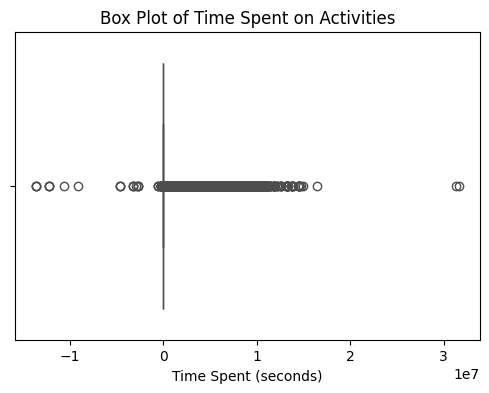

Nb of rows where the length of the activity is negative or zero: 26495


In [10]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=activity['time_spent'], color='blue')
plt.xlabel('Time Spent (seconds)')
plt.title('Box Plot of Time Spent on Activities')
plt.show()

print('Nb of rows where the length of the activity is negative or zero:', activity[activity['time_spent'] <= 0].shape[0])

- Since there are few we decided to remove the problematic rows 

In [11]:
activity = activity[activity['time_spent'] > 0]

- How much data did we lose?

In [12]:
activity_data_loss = activity.shape[0]/activity_og.shape[0]
print('Percent of original data lost', 100 - activity_data_loss * 100)

Percent of original data lost 44.91363089284807


- Now lets look at the distribution of time spent on activities

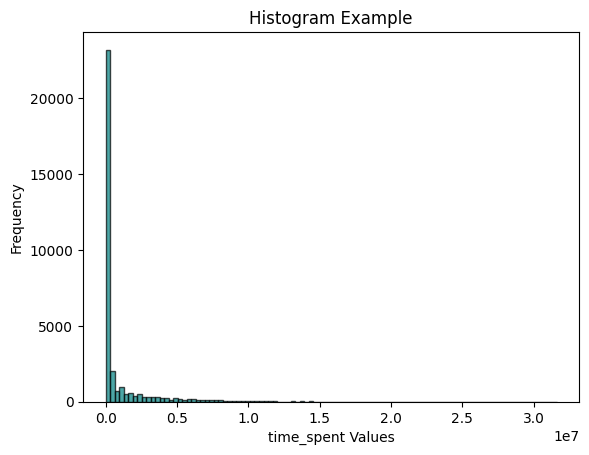

In [13]:
data = activity['time_spent']

plt.hist(data, bins=100, color='teal', edgecolor='black', alpha=0.7)
plt.title('Histogram Example')
plt.xlabel('time_spent Values')
plt.ylabel('Frequency')
plt.show()

- There seems to be some outliers, so lets remove some activities that seem to be taking too long -----> NEED TO DECIDE WHAT TOO LONG IS 

In [14]:
activity.groupby(by='activity_type')['time_spent'].describe()

,count,mean,std,min,25%,50%,75%,max
activity_type,,,,,,,,
access,135.0,4.203037e+02,2.694136e+03,2.0,6.0,7.0,8.00,18223.0
course,1672.0,3.433625e+06,3.485848e+06,1.0,345494.0,2432481.5,5737739.75,31618839.0
exam,394.0,7.022218e+03,2.383318e+04,1.0,1203.0,2125.5,3289.75,236754.0
group_progress,29.0,4.104712e+06,3.022342e+06,509447.0,1830454.0,3596969.0,5193789.00,11038258.0
lesson,3126.0,2.322852e+06,2.800233e+06,1.0,61013.0,1148538.5,3631964.00,14517474.0
quiz,5299.0,1.584355e+03,7.724237e+03,3.0,124.0,459.0,1369.50,446287.0
topic,21841.0,6.007400e+05,1.453027e+06,1.0,138.0,1282.0,424028.00,14517437.0


In [15]:
quantiles = activity.groupby(by='activity_type')['time_spent'].quantile(0.95)

activity = activity[activity.apply(lambda row: row['time_spent'] <= quantiles[row['activity_type']], axis=1)]

- Now lets's see how much data deleted overall :

In [16]:
activity_data_loss = activity.shape[0]/activity_og.shape[0]
print('Percent of data lost', 100 - activity_data_loss * 100)

Percent of data lost 47.669983556813754


## Cleaning the test data

### all_scores datframe

In [17]:
all_scores_og = all_scores.copy()

- First lets see if there are any missing or problematic values

In [18]:
all_scores.isnull().sum().reset_index(name='Nb of NAN')

,index,Nb of NAN
0,Unnamed: 0,0
1,user_id,0
2,test_id,0
3,course,0
4,percentage,0
5,time,0


In [19]:
all_scores[all_scores['time'] < '2023-01-01']

,Unnamed: 0,user_id,test_id,course,percentage,time


- No problematic values so now let's see if some users redid the same exam more than once

In [20]:
attempt_count = all_scores.groupby(['user_id', 'test_id','course']).size().reset_index(name='attempt_count')

attempt_count[attempt_count['attempt_count'] > 1].shape[0]

441

- Let's get rid of everything past the first attempt ----> HERE DISCUSS

In [21]:
all_scores = all_scores.sort_values(by='time')

all_scores = all_scores.groupby(['user_id', 'test_id','course']).first().reset_index()

- Now lets's see how much data deleted overall :

In [22]:
all_scores_data_loss = all_scores.shape[0]/all_scores_og.shape[0]
print('Percent of data lost', 100 - all_scores_data_loss * 100)

Percent of data lost 26.754617414248017


# Now let's export our cleaned data !

In [23]:
# Uncomment this to save the cleaned dataframes :)

# activity.to_csv('activity_cleaned.csv', index=False)    
# all_scores.to_csv('all_scores_cleaned.csv', index=False)        